# Testing Paolina on output of Penthesilea (run on NEW data)

In [1]:
%matplotlib inline

import os
import sys
import random
import tables as tb
import numpy  as np

import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

from   invisible_cities.reco.paolina_functions import \
            Voxel, build_voxels, calc_adj_matrix, construct_tracks, calc_dist_mat, construct_blobs
from   invisible_cities.cities.penthesilea import Penthesilea, PENTHESILEA
from   invisible_cities.database import load_db
from   invisible_cities.core.system_of_units_c import units
from   invisible_cities.reco.pmaps_functions import load_pmaps, integrate_charge, plot_s2si_map, select_si_slice
from   invisible_cities.reco.tbl_functions     import get_event_numbers_and_timestamps
from   invisible_cities.reco.xy_algorithms import barycenter, corona
from   invisible_cities.reco.dst_io import Hit, HitCollection

#from   icaro.core.kdst_functions import load_dst, event_rate, profile_and_fit, print_fit, chi2
from invisible_cities.core.core_functions import in_range

NSIPM = 1792

In [ ]:
conf_file_name = os.path.join(os.environ['ICDIR']) + 'config/penthesilea.conf'
PENTHESILEA(['PENTHESILEA', '-c', conf_file_name])

In [2]:
# read in the output HitCollection
fn = tb.open_file('/Users/jrenner/IFIC/IC-1/invisible_cities/database/test_data/NaTracks_3755.h5','r')
tracks = fn.root.DST.Tracks
nmax = 17468

# loop over all events
rnum = 0       # row number in table iteration
ev = 0         # processed event number
hc_evt = []
while(rnum < tracks.nrows and ev < nmax):
    
    # create a HitCollection
    hitc = HitCollection()

    # fill the hit for this event
    evtnum = tracks[rnum]['event']
    while(rnum < tracks.nrows and tracks[rnum]['event'] == evtnum):
        hit       = Hit()
        hit.Npeak = tracks[rnum]['npeak']
        hit.X     = tracks[rnum]['X']
        hit.Y     = tracks[rnum]['Y']
        hit.R     = tracks[rnum]['R']
        hit.Phi   = tracks[rnum]['Phi']
        hit.Nsipm = tracks[rnum]['Nsipm']
        hit.Z     = tracks[rnum]['Z']
        hit.Q     = tracks[rnum]['Q']
        hit.E     = tracks[rnum]['E']
        hit.Ecorr = tracks[rnum]['Ecorr']
        hitc.append(hit)
        rnum += 1
    
    # add this hit collection to the list of hit collections
    hc_evt.append(hitc)
    ev += 1

print("Read in {0} events".format(len(hc_evt)))

Read in 6933 events


# Paolina analysis

In [3]:
vol_min = np.array([-250, -250, -100],dtype=np.int16)  # volume minimum (x,y,z)
vol_max = np.array([250, 250, 800],dtype=np.int16)  # volume maximum (x,y,z)
vox_size = np.array([10, 10, 5],dtype=np.int16)    # voxel size
blob_radius = 15.                    # blob radius in mm
Ecut_low = 80000
Ecut_high = 109000
Ecut_low_blobs = 4000

## Individual tracks

(array([ 141.,  254.,  296.,  317.,  296.,  277.,  318.,  372.,  407.,
         413.,  398.,  350.,  252.,  199.,  216.,  300.,  422.,  645.,
         500.,  273.,   81.,   29.,   20.,   18.,   12.,   10.,    7.,
           4.,    6.,    5.,    6.,    5.,    3.,    4.,    4.,    3.,
           5.,    1.,    3.,    0.,    1.,    2.,    2.,    1.,    0.,
           0.,    2.,    0.,    0.,    1.,    1.,    1.,    5.,    0.,
           1.,    1.,    1.,    2.,    1.,    1.,    2.,    0.,    2.,
           1.,    2.,    2.,    1.,    1.,    1.,    2.,    1.,    3.,
           1.,    2.,    4.,    0.,    0.,    1.,    1.,    0.,    1.,
           0.,    1.,    0.,    0.,    0.,    0.,    0.,    1.,    0.,
           1.,    2.,    0.,    1.,    0.,    1.,    1.,    1.,    0.,    1.]),
 array([    692.53688049,    5929.00662277,   11165.47636505,
          16401.94610733,   21638.41584961,   26874.88559189,
          32111.35533417,   37347.82507645,   42584.29481873,
          47820.764561  

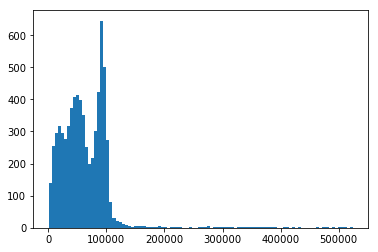

In [4]:
e_spec = []
for ee in range(len(hc_evt)):
    evt_E = sum([hh.E for hh in hc_evt[ee]])
    e_spec.append(evt_E)
    #if(evt_E > 200000): print(ee)
    #print("Event {0} with total energy {1}".format(ee,evt_E))
plt.hist(e_spec,bins=100)

In [ ]:
# perform the Paolina analysis for a single event
ee = 3768
hitc = hc_evt[ee]
evt_E = sum([hh.E for hh in hitc])
print("Event {0} with total energy {1}".format(ee,evt_E))

voxelc = build_voxels(hitc)
adj_mat = calc_adj_matrix(voxelc)
itmax,trks = construct_tracks(voxelc,adj_mat)
dist_mat, spath = calc_dist_mat(trks[itmax])
Eblob1, Eblob2 = construct_blobs(trks[itmax],dist_mat,spath)

# plot the voxelized tracks
# 2D histogram
fig = plt.figure(3);
fig.set_figheight(5.0);
fig.set_figwidth(20.0);

varr_x = []; varr_y = []; varr_z = []; varr_c = []
for vv in trks[itmax]:
#for vv in voxelc:
    varr_x.append(vv.X)
    varr_y.append(vv.Y)
    varr_z.append(vv.Z)
    varr_c.append(vv.E)

vtrk_max = np.array([np.max(varr_x),np.max(varr_y),np.max(varr_z)])
vtrk_min = np.array([np.min(varr_x),np.min(varr_y),np.min(varr_z)])

# create the x-y projection
ax1 = fig.add_subplot(131);
hxy, xxy, yxy = np.histogram2d(varr_y, varr_x, weights=varr_c, normed=False, bins=(1.0*(vol_max[1]-vol_min[1])/vox_size[1], 1.0*(vol_max[0]-vol_min[0])/vox_size[0]), range=[[vol_min[1],vol_max[1]],[vol_min[0],vol_max[0]]])
extent1 = [yxy[0], yxy[-1], xxy[0], xxy[-1]]
sp1 = ax1.imshow(hxy, extent=extent1, interpolation='none', aspect='auto', origin='lower', cmap='jet')
ax1.set_xlabel("x (mm)")
ax1.set_ylabel("y (mm)")
cbp1 = plt.colorbar(sp1)
cbp1.set_label('Energy (Q)')

# Create the y-z projection.
ax2 = fig.add_subplot(132);
hyz, xyz, yyz = np.histogram2d(varr_z, varr_y, weights=varr_c, normed=False, bins=(1.0*(vol_max[2]-vol_min[2])/vox_size[2], 1.0*(vol_max[1]-vol_min[1])/vox_size[1]), range=[[vol_min[2],vol_max[2]],[vol_min[1],vol_max[1]]])
extent2 = [yyz[0], yyz[-1], xyz[0], xyz[-1]]
sp2 = ax2.imshow(hyz, extent=extent2, interpolation='none', aspect='auto', origin='lower', cmap='jet')
ax2.set_xlabel("y (mm)")
ax2.set_ylabel("z (mm)")
cbp2 = plt.colorbar(sp2);
cbp2.set_label('Energy (Q)');

# Create the x-z projection.
ax3 = fig.add_subplot(133);
hxz, xxz, yxz = np.histogram2d(varr_z, varr_x, weights=varr_c, normed=False, bins=(1.0*(vol_max[2]-vol_min[2])/vox_size[2], 1.0*(vol_max[0]-vol_min[0])/vox_size[0]), range=[[vol_min[2],vol_max[2]],[vol_min[0],vol_max[0]]])
extent3 = [yxz[0], yxz[-1], xxz[0], xxz[-1]]
sp3 = ax3.imshow(hxz, extent=extent3, interpolation='none', aspect='auto', origin='lower', cmap='jet')
ax3.set_xlabel("x (mm)")
ax3.set_ylabel("z (mm)")
cbp3 = plt.colorbar(sp3);
cbp3.set_label('Energy (Q)');

## All events

In [22]:
# perform the Paolina analysis for all events
l_eblob1 = []; l_eblob2 = []   # blob energies
l_hcindex = []                 # index of hit in hit collection
l_trklen = []                  # track length (longest Paolina track)
l_dblobs = []                  # absolute distance between two blobs
l_zlen = []                    # z-extent of event
l_etot = []; l_etotcorr = []   # total event energy (uncorrected and corrected)
l_etrack = []; l_eltrack = []  # energy of all tracks and of longest track
l_ntracks = []; l_nhits = []   # number of tracks and number of hits
l_nhtrk = []; l_nhltrk = []    # number of hits per track for all tracks and longest track
l_ehits = []; l_lehits = []    # hit energy distribution for all tracks and longest track

evt_ct = 0
for hitc in hc_evt:
    
    if(evt_ct % int(len(hc_evt) / 10) == 0):
        print("Event {0} of {1}...".format(evt_ct,len(hc_evt)))
    
    voxelc = build_voxels(hitc)
    adj_mat = calc_adj_matrix(voxelc)
    itmax,trks = construct_tracks(voxelc,adj_mat)
    
    # only include events for which the longest track had > 1 voxel
    evt_E = sum([hh.E for hh in hitc])
    #if(len(trks[itmax]) > 1):
    if(len(trks[itmax]) > 1 and evt_E > Ecut_low and evt_E < Ecut_high):
        dist_mat, spath = calc_dist_mat(trks[itmax])
        Eblob1, Eblob2 = construct_blobs(trks[itmax],dist_mat,spath)
        vb1 = spath[0]; vb2 = spath[-1]
        
        # construct key quantities (event-scale)
        evt_Ecorr = sum([hh.Ecorr for hh in hitc])
        ltrk_E = sum([vv.E for vv in trks[itmax]])
        min_z = min([hh.Z for hh in hitc])
        max_z = max([hh.Z for hh in hitc])
        dblob = np.sqrt((vb1.X - vb2.X)**2 + (vb1.Y - vb2.Y)**2 + (vb1.Z - vb2.Z)**2)
    
        # ensure blob2 always has higher energy
        if(Eblob1 > Eblob2):
            eswap = Eblob1
            Eblob1 = Eblob2
            Eblob2 = eswap
        
        # add distribution information (event-scale)
        l_eblob1.append(Eblob1)
        l_eblob2.append(Eblob2)
        l_hcindex.append(evt_ct)
        l_trklen.append(dist_mat[vb1.tID][vb2.tID])
        l_dblobs.append(dblob)
        l_zlen.append(max_z - min_z)
        l_etot.append(evt_E)
        l_etotcorr.append(evt_Ecorr)
        
        l_eltrack.append(ltrk_E)
        l_ntracks.append(len(trks))
        l_nhits.append(len(hitc))
        
        # add distribution information (track-scale)
        for tk in trks:
            tk_nhits = len(tk)
            tk_E = sum([vv.E for vv in tk])
            l_etrack.append(tk_E)
            
            l_nhtrk.append(len(tk))            
            if(tk == trks[itmax]): l_nhltrk.append(len(tk))
            for vv in tk:
                l_ehits.append(vv.E)
                if(tk == trks[itmax]): l_lehits.append(vv.E)

    evt_ct += 1
    
# convert to numpy arrays
l_zlen = np.array(l_zlen)
l_hcindex = np.array(l_hcindex)
l_eblob1 = np.array(l_eblob1)
l_eblob2 = np.array(l_eblob2)
l_trklen = np.array(l_trklen)
l_etot = np.array(l_etot)
l_etotcorr = np.array(l_etotcorr)

Event 0 of 6933...
Event 693 of 6933...
Event 1386 of 6933...
Event 2079 of 6933...
Event 2772 of 6933...
Event 3465 of 6933...
Event 4158 of 6933...
Event 4851 of 6933...
Event 5544 of 6933...
Event 6237 of 6933...
Event 6930 of 6933...


### Plot energy distributions

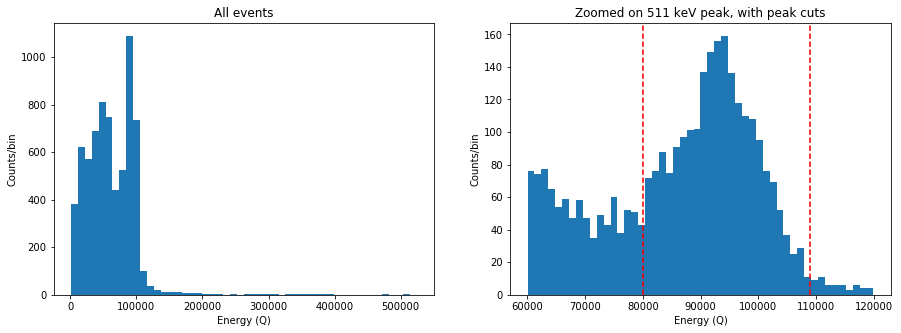

In [6]:
fig = plt.figure(3);
fig.set_figheight(5.0);
fig.set_figwidth(15.0);

# full energy spectrum
ax1 = fig.add_subplot(121);
plt.hist(l_etot,bins=50)
ax1.set_title("All events")
ax1.set_xlabel("Energy (Q)")
ax1.set_ylabel("Counts/bin")

# zoomed energy spectrum
ax2 = fig.add_subplot(122);
plt.hist(l_etot[((l_etot > 60000) & (l_etot < 120000))],bins=50)
plt.axvline(x=Ecut_low,color='red',linestyle='--')
plt.axvline(x=Ecut_high,color='red',linestyle='--')
ax2.set_title("Zoomed on 511 keV peak, with peak cuts")
ax2.set_xlabel("Energy (Q)")
ax2.set_ylabel("Counts/bin")

# zoomed, corrected energy
#ax3 = fig.add_subplot(133);
#plt.hist(l_etotcorr[((l_etotcorr > 150000) & (l_etotcorr < 200000))],bins=50)
#plt.axvline(x=Ecut_low,color='red',linestyle='--')
#plt.axvline(x=Ecut_high,color='red',linestyle='--')
#ax3.set_title("Zoomed on 511 keV peak, with peak cuts")
#ax3.set_xlabel("Energy (Q)")
#ax3.set_ylabel("Counts/bin")

### Plot blob energies for events in the peak 

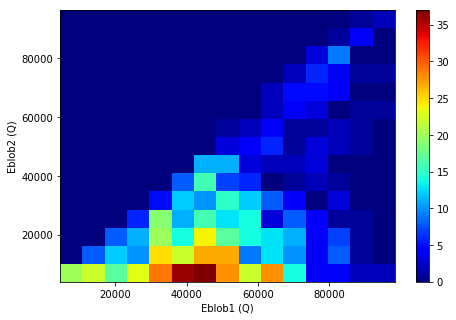

In [10]:
# 2D histogram
fig = plt.figure(3);
fig.set_figheight(5.0);
fig.set_figwidth(7.5);

# create the x-y projection
hxy, xxy, yxy = np.histogram2d(l_eblob1[((l_etot > Ecut_low) & (l_etot < Ecut_high) & (l_eblob1 > Ecut_low_blobs) & (l_eblob2 > Ecut_low_blobs))], l_eblob2[((l_etot > Ecut_low) & (l_etot < Ecut_high) & (l_eblob1 > Ecut_low_blobs) & (l_eblob2 > Ecut_low_blobs))], normed=False, bins=(15, 15))
extent1 = [yxy[0], yxy[-1], xxy[0], xxy[-1]]
sp1 = plt.imshow(hxy, extent=extent1, interpolation='none', aspect='auto', origin='lower', cmap='jet')
plt.xlabel("Eblob1 (Q)")
plt.ylabel("Eblob2 (Q)")
plt.colorbar()

### Plot track length vs. energy

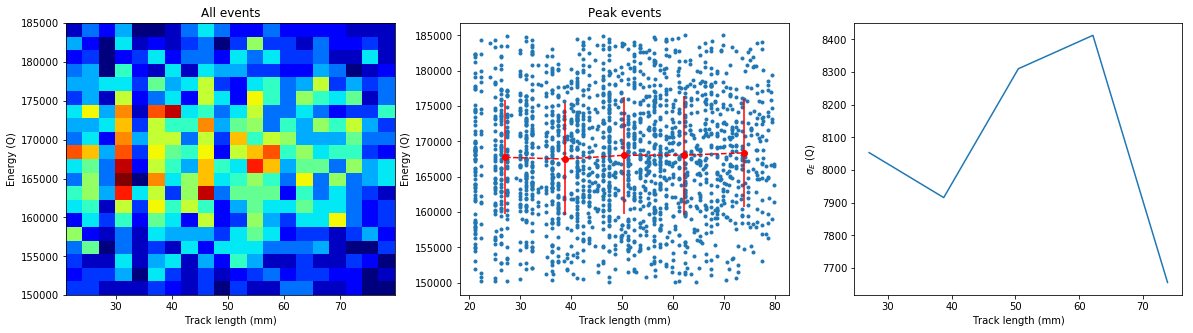

In [11]:
#cuts_allE = (l_trklen < 400)
#cuts_allE = (l_trklen < 30) & (l_etotcorr < 250000) & (l_trklen > 15)
cuts_allE = (l_trklen < 80) & (l_etotcorr < 250000) & (l_trklen > 20)
cuts_peakE = ((l_etotcorr > 150000) & (l_etotcorr < 185000)) & (l_trklen < 80) & (l_trklen > 20)

fig = plt.figure(3);
fig.set_figheight(5.0);
fig.set_figwidth(20.0);

# plot for all energies
ax1 = fig.add_subplot(131);
xcounts, xc_edges = np.histogram(l_trklen[cuts_allE],bins=10)
xhist, xbin_edges = np.histogram(l_trklen[cuts_allE],weights=l_etotcorr[cuts_allE],bins=10)
xbin_width = xbin_edges[1] - xbin_edges[0]
xbin_centers = xbin_edges[:-1] + xbin_width/2.
xhist /= xcounts
#plt.scatter(l_zlen[cuts_allE],l_etot[cuts_allE],marker='.')
hxy, xxy, yxy = np.histogram2d(l_etotcorr[cuts_peakE], l_trklen[cuts_peakE], normed=False, bins=(20, 20))
extent1 = [yxy[0], yxy[-1], xxy[0], xxy[-1]]
sp1 = plt.imshow(hxy, extent=extent1, interpolation='none', aspect='auto', origin='lower', cmap='jet')
#plt.plot(xbin_centers,xhist,marker='.',color='red')
ax1.set_title("All events")
ax1.set_xlabel("Track length (mm)")
ax1.set_ylabel("Energy (Q)")

# plot for peak energies
ax2 = fig.add_subplot(132);
tvals = l_trklen[cuts_peakE]
evals = l_etotcorr[cuts_peakE]
nbins = 5

# place all values in bins
l_tbins = []
for nn in range(nbins):
    l_tbins.append([])
tmin = np.min(tvals); tmax = np.max(tvals); trng = tmax-tmin
for tv,ev in zip(tvals,evals):
    bb = min(int(nbins*(tv-tmin)/trng),nbins-1)
    l_tbins[bb].append(ev)
l_tbins = np.array(l_tbins)

# calculate means and errors
xbin_centers = []
muvals = []; stdevals = []
bwidth = trng/nbins
for nbin,tbin in enumerate(l_tbins):
    if(len(tbin) > 20):
        muvals.append(np.mean(tbin))
        stdevals.append(np.std(tbin))
        xbin_centers.append(tmin + nbin*bwidth + bwidth/2.)

plt.scatter(l_trklen[cuts_peakE],l_etotcorr[cuts_peakE],marker='.')
plt.errorbar(xbin_centers,muvals,yerr=stdevals,color='red',fmt='--o')
ax2.set_title("Peak events")
ax2.set_xlabel("Track length (mm)")
ax2.set_ylabel("Energy (Q)")

ax2 = fig.add_subplot(133);
plt.plot(xbin_centers,stdevals)
ax2.set_xlabel("Track length (mm)")
ax2.set_ylabel("$\sigma_E$ (Q)")

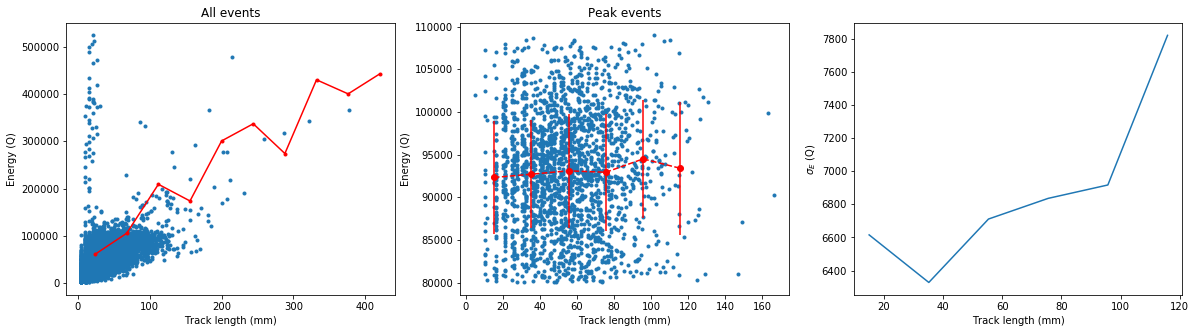

In [12]:
cuts_allE = (l_trklen < 400)
cuts_peakE = ((l_etot > Ecut_low) & (l_etot < Ecut_high))

fig = plt.figure(3);
fig.set_figheight(5.0);
fig.set_figwidth(20.0);

# plot for all energies
ax1 = fig.add_subplot(131);
xcounts, xc_edges = np.histogram(l_zlen[cuts_allE],bins=10)
xhist, xbin_edges = np.histogram(l_zlen[cuts_allE],weights=l_etot[cuts_allE],bins=10)
xbin_width = xbin_edges[1] - xbin_edges[0]
xbin_centers = xbin_edges[:-1] + xbin_width/2.
xhist /= xcounts
plt.scatter(l_trklen[cuts_allE],l_etot[cuts_allE],marker='.')
plt.plot(xbin_centers,xhist,marker='.',color='red')
ax1.set_title("All events")
ax1.set_xlabel("Track length (mm)")
ax1.set_ylabel("Energy (Q)")

# plot for peak energies
ax2 = fig.add_subplot(132);
tvals = l_trklen[cuts_peakE]
evals = l_etot[cuts_peakE]
nbins = 8

# place all values in bins
l_tbins = []
for nn in range(nbins):
    l_tbins.append([])
tmin = np.min(tvals); tmax = np.max(tvals); trng = tmax-tmin
for tv,ev in zip(tvals,evals):
    bb = min(int(nbins*(tv-tmin)/trng),nbins-1)
    l_tbins[bb].append(ev)
l_tbins = np.array(l_tbins)

# calculate means and errors
xbin_centers = []
muvals = []; stdevals = []
bwidth = trng/nbins
for nbin,tbin in enumerate(l_tbins):
    if(len(tbin) > 20):
        muvals.append(np.mean(tbin))
        stdevals.append(np.std(tbin))
        xbin_centers.append(tmin + nbin*bwidth + bwidth/2.)

plt.scatter(l_trklen[cuts_peakE],l_etot[cuts_peakE],marker='.')
plt.errorbar(xbin_centers,muvals,yerr=stdevals,color='red',fmt='--o')
ax2.set_title("Peak events")
ax2.set_xlabel("Track length (mm)")
ax2.set_ylabel("Energy (Q)")

ax2 = fig.add_subplot(133);
plt.plot(xbin_centers,stdevals)
ax2.set_xlabel("Track length (mm)")
ax2.set_ylabel("$\sigma_E$ (Q)")

### Print event numbers of selected events

In [13]:
cuts_peakE = ((l_etot > Ecut_low) & (l_etot < Ecut_high))
cuts_long = (l_trklen > 400)

print("Events in peak:")
pk_evts = [ii for ii,cc in enumerate(cuts_peakE) if cc]
print("Indices:",l_hcindex[pk_evts[0:10]])
print("With energies:",l_etot[pk_evts[0:10]])

print("\nLong events:")
long_evts = [ii for ii,cc in enumerate(cuts_long) if cc]
print("Indices:",l_hcindex[long_evts])
print("With length:",l_trklen[long_evts])
print("And energy:",l_etot[long_evts])

Events in peak:
Indices: [ 1  2  4  5  7  8  9 17 18 21]
With energies: [  97895.78857422   93647.75773621  100198.67700195   93211.83000183
   86242.86819458   97794.07162476   90939.12504578   93942.60995483
   88888.75759888   96209.24942017]

Long events:
Indices: [3768 4581 4698]
With length: [ 748.14329595  428.71630892  709.79329761]
And energy: [ 482047.3946228   392020.97268677  348345.9831543 ]


## Control histograms

### Energy per hit

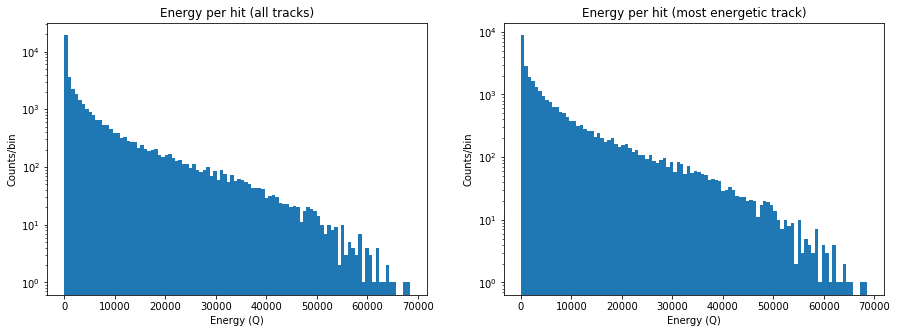

In [37]:
fig = plt.figure(1);
fig.set_figheight(5.0);
fig.set_figwidth(15.0);

# all track
ax1 = fig.add_subplot(121);
plt.hist(l_ehits,bins=100)
ax1.set_title("Energy per hit (all tracks)")
ax1.set_xlabel("Energy (Q)")
ax1.set_ylabel("Counts/bin")
ax1.set_yscale("log")

# most energetic track only
ax2 = fig.add_subplot(122);
plt.hist(l_lehits,bins=100)
ax2.set_title("Energy per hit (most energetic track)")
ax2.set_xlabel("Energy (Q)")
ax2.set_ylabel("Counts/bin")
ax2.set_yscale("log")

### Number of hits and number of tracks in total

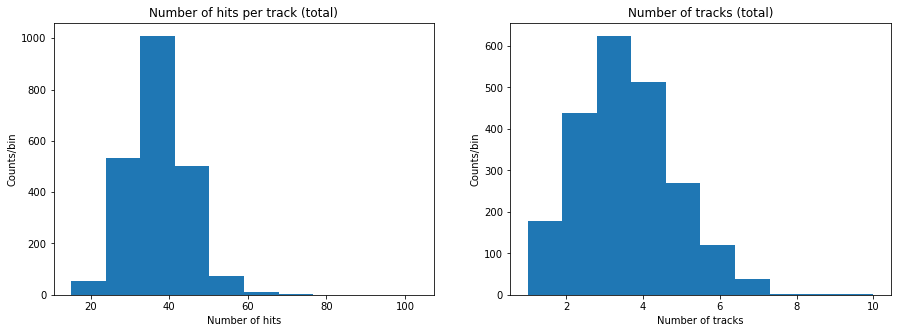

In [38]:
fig = plt.figure(1);
fig.set_figheight(5.0);
fig.set_figwidth(15.0);

# all track
ax1 = fig.add_subplot(121);
plt.hist(l_nhits,bins=10)
ax1.set_title("Number of hits per track (total)")
ax1.set_xlabel("Number of hits")
ax1.set_ylabel("Counts/bin")
#ax1.set_yscale("log")

# most energetic track only
ax2 = fig.add_subplot(122);
plt.hist(l_ntracks,bins=10)
ax2.set_title("Number of tracks (total)")
ax2.set_xlabel("Number of tracks")
ax2.set_ylabel("Counts/bin")
#ax2.set_yscale("log")

### Number of hits per track

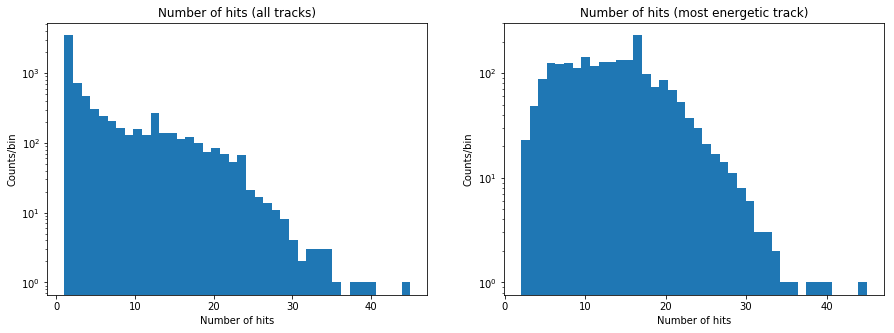

In [39]:
fig = plt.figure(1);
fig.set_figheight(5.0);
fig.set_figwidth(15.0);

# all track
ax1 = fig.add_subplot(121);
plt.hist(l_nhtrk,bins=40)
ax1.set_title("Number of hits (all tracks)")
ax1.set_xlabel("Number of hits")
ax1.set_ylabel("Counts/bin")
ax1.set_yscale("log")

# most energetic track only
ax2 = fig.add_subplot(122);
plt.hist(l_nhltrk,bins=40)
ax2.set_title("Number of hits (most energetic track)")
ax2.set_xlabel("Number of hits")
ax2.set_ylabel("Counts/bin")
ax2.set_yscale("log")

### Track energies

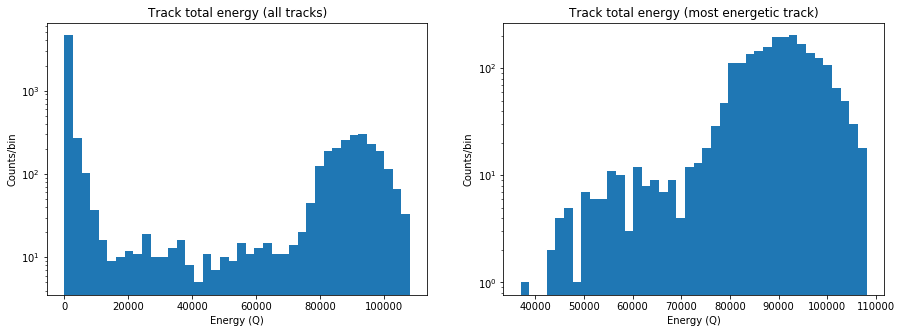

In [40]:
fig = plt.figure(1);
fig.set_figheight(5.0);
fig.set_figwidth(15.0);

# all track
ax1 = fig.add_subplot(121);
plt.hist(l_etrack,bins=40)
ax1.set_title("Track total energy (all tracks)")
ax1.set_xlabel("Energy (Q)")
ax1.set_ylabel("Counts/bin")
ax1.set_yscale("log")

# most energetic track only
ax2 = fig.add_subplot(122);
plt.hist(l_eltrack,bins=40)
ax2.set_title("Track total energy (most energetic track)")
ax2.set_xlabel("Energy (Q)")
ax2.set_ylabel("Counts/bin")
ax2.set_yscale("log")

### Track lengths and blob distances

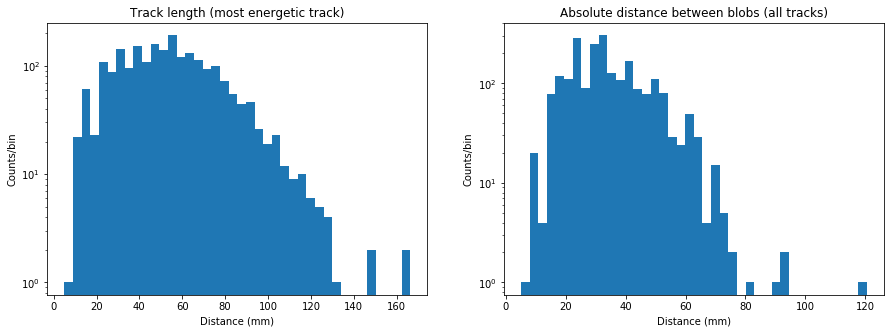

In [41]:
fig = plt.figure(1);
fig.set_figheight(5.0);
fig.set_figwidth(15.0);

# length
ax1 = fig.add_subplot(121);
plt.hist(l_trklen,bins=40)
ax1.set_title("Track length (most energetic track)")
ax1.set_xlabel("Distance (mm)")
ax1.set_ylabel("Counts/bin")
ax1.set_yscale("log")

# distance between blobs
ax2 = fig.add_subplot(122);
plt.hist(l_dblobs,bins=40)
ax2.set_title("Absolute distance between blobs (all tracks)")
ax2.set_xlabel("Distance (mm)")
ax2.set_ylabel("Counts/bin")
ax2.set_yscale("log")